In [32]:
import glob
import os
import re
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy import linalg
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
from sklearn.cluster import KMeans, DBSCAN, MeanShift, estimate_bandwidth
from sklearn.neighbors import NearestNeighbors

## Short Conclusion to the subject task:
Two clusterization algorithms were used for subject task: K-Mean (input a number of clusters) and DBSCAN (do not need the number of clusters as an input). Also visual analysis application made a contribution for providing a "simple" answer. 
There are different decisions  from different approaches. Which approach to use? It is up to task we try to solve. There may be constraints or additional information. It should be noted that visual observation provide a more strict number of clusters, K-Means and DBSCAN clusters number may be discussed and depend on parameters or Elbow curve interpretation. 
#### Also K-Mean and DBSCAN (in the current implementation with current used parameters for MinPts and Eps) can have a same answer - 8 clusters.

## The coordinates should be extracted from the text files. Also a little cleaning is necessary. All aggragated coordinates will be saved in 'Demo.csv' file for furthe access. 

In [2]:
os.getcwd()

'C:\\Users\\gj310e\\Big Data with Python\\DeckRobot'

In [3]:
# Extract the files from archive in the folder /Demo
# Extract the names of text files with coordinates
names = glob.glob("Demo/*.txt")

In [4]:
# Function extract a coordinates from the text file. The regular expression is used to clean a data (there is no clearly 
# coordinates, (for example '24-52'), so the first number is taken)
def extr(name):
    X=[]
    Y=[]
    Z=[]
    with open(name, 'r') as fd:
        for line in fd:
            line = line.strip()
            data = line.split(',')
            x = int(str(re.findall("([-|+]*\d*)", data[0])[0]))
            y = int(str(re.findall("([-|+]*\d*)", data[1])[0]))
            z = int(str(re.findall("([-|+]*\d*)", data[2])[0]))
            X.append(x)
            Y.append(y)
            Z.append(z)
    return X, Y, Z

In [5]:
#Extract all X,Y,Z coordinates to the lists
X=[]
Y=[]
Z=[]
for name in names:
    x, y, z = extr(name)
    X = X + x
    Y = Y + y
    Z = Z +z

In [6]:
len(X), len(Y), len(Z)

(59440, 59440, 59440)

In [7]:
#Create a dataframe with coordinates
d = {'X': X, 'Y': Y, 'Z' : Z}
data = pd.DataFrame(data = d)

In [8]:
#Export dataframe to the csv file for further use it without above processes
#data.to_csv('Demo.csv')

In [9]:
#Start from here if coordinates were aggregated to the Demo.csv file
#data = pd.read_csv('Demo.csv')

## Data visualization

#### Try to visualize a data using a PCA, to reduce a dimensions to two and one

In [10]:
# Lets try to look at data after PCA dimensional reduction

# Standardizing the data. The scaled data will be used in further analysis
d = np.array(data)
scaler = StandardScaler()
scaler.fit(data)
d_sc = scaler.transform(d)

U, S, V = linalg.svd(d_sc.T, full_matrices=False)

d_x = np.dot(d_sc, U[0])
d_y = np.dot(d_sc, U[1])

C:\Roman Kutskyi\Anaconda\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### The plotted results do not allow to determine a number of clusters easily (by visual observations)

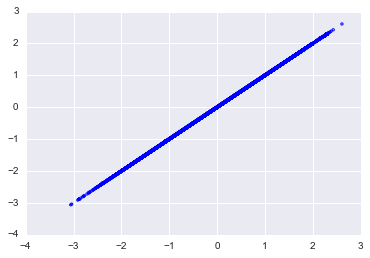

In [11]:
plt.scatter(d_x, d_x, s=5, edgecolors='b',facecolors='None', linewidth=1)

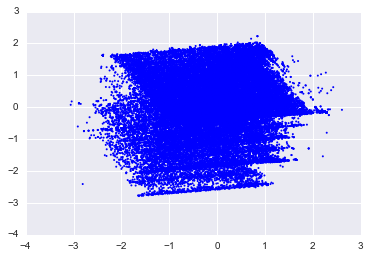

In [12]:
plt.scatter(d_x, d_y, s=1, edgecolors='b',facecolors='None', linewidth=1)

### Now lets visualize the data set at 2-dimensional space: (x,y); (x,z); (y,z)
#### As a result, there may be defined a 7 clusters base on the value of Z coordinate, other point may be just a noize. This is most simple way, to make a decision by visual observations.

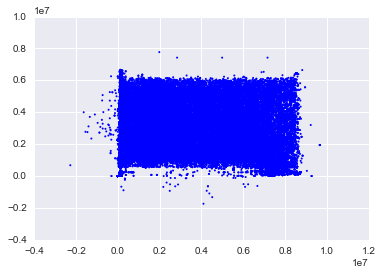

In [13]:
plt.scatter(d[:,0], d[:,1], s=1, edgecolors='b',facecolors='None', linewidth=1)

#### There are 7 clusters in the figures below

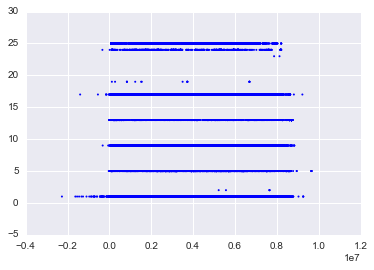

In [14]:
plt.scatter(d[:,0], d[:,2], s=1, edgecolors='b',facecolors='None', linewidth=1)

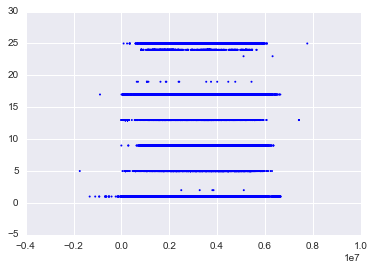

In [15]:
plt.scatter(d[:,1], d[:,2], s=1, edgecolors='b',facecolors='None', linewidth=1)

### Conclusion for simple observation:
#### There are 7 clusters can be defined base on Z-coordinate, other points may be just a noize. It could be a true clusterization if in Z parameter we have a very important business parameter, which determine our target (for example)

### K-Mean Cost function will be checked for different numbers of clusters, also the Elbow-curve method will be applied to determine the optimal K.

In [16]:
# means.inertia_ define the cost function in sklearn
cost = []
k = []
for i in range(1,21):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(d)
    cost.append(kmeans.inertia_)
    k.append(i)

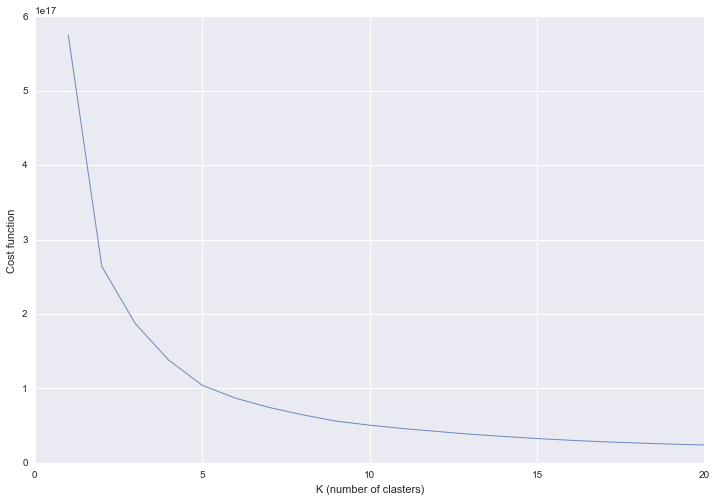

In [17]:
# Visualize how a cost function depend on number of clusters
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(k, cost, linewidth = 1, alpha = 0.8)
ax.set_xlabel('K (number of clasters)')
ax.set_ylabel('Cost function')

### Conclusion for K-Means:

#### According to the Cost_function curve above there are 5 clusters in the dataset (it is not clearly visible, also 8 clusters seems may provide the optimal solution)



### Now DBSCAN will be applied, it do not need to input a number of clusters. 
DBSCAN is an acronym that stands for density-based spatial clustering with noise. It can also find points that are outliers that shouldn't reasonably be assigned to any cluster. DBSCAN works with data with complex cluster shapes. EPS parameter implicitly control the number of clusters, it will be culculated base on the Nearest Neighbors distances (see also the following articles for more methodology explanation: 

1)'International Journal of Signal Processing, Image Processing and Pattern Recognition', Vol. 6, No. 1, February, 2013: 'A Dynamic Method for Discovering Density Varied Clusters'

2)'Earth and Environmental Science', January 2012, 'Determination of Optimal Epsilon (Eps) Value on DBSCAN Algorithm to
Clustering Data on Peatland Hotspots in Sumatra'
 
 The MinPts (min_samples in skilearn, the number of samples (or total weight) in a neighborhood for a point to be considered as a core point). Assumed as 10, generally this parameter should correspond to the number of nearest neighbors for (eps).

In [18]:
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(d_sc)

In [19]:
distances, indices = nbrs.kneighbors(d_sc)

In [20]:
dist = distances.mean(axis = 1)

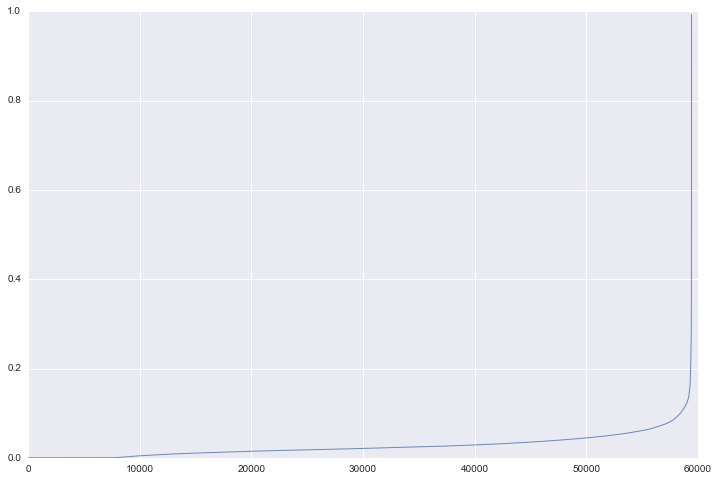

In [21]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(np.sort(dist), linewidth = 1, alpha = 0.8)

### The 'Knee' at the plot above correspond to 0.17 distance

In [22]:
db = DBSCAN(eps=0.17,min_samples=10, random_state= 0).fit(d_sc)
distances, indices = nbrs.kneighbors(d_sc)

C:\Roman Kutskyi\Anaconda\lib\site-packages\sklearn\cluster\dbscan_.py:116: DeprecationWarning: The parameter random_state is deprecated in 0.16 and will be removed in version 0.18. DBSCAN is deterministic except for rare border cases.
  category=DeprecationWarning)


In [23]:
# the number of unique clusters
len(set(db.labels_))

9

In [24]:
print(set(db.labels_))

{0, 1, 2, 3, 4, 5, 6, 7, -1}


### Conclusion for DBSCAN:  
#### Noisy samples are given the label -1, so there are 8 clusters (9 - 1). Note that DBSCAN very sencitive from MinPts and Epsilon values, so the number of clusters may be adjusted.

# Mean-Shift Clusterization
The algorithm is time consumed

In [35]:
bandwidth = estimate_bandwidth(d_sc, quantile=0.2)
# (n_samples) may be added (for example: n_samples=1000)

In [36]:
bandwidth

1.5177878009763905

In [26]:
meanshift = MeanShift(bandwidth = bandwidth).fit(d_sc)

In [27]:
cluster_centers = meanshift.cluster_centers_

In [28]:
cluster_centers

array([[-0.13301577,  0.10558441, -0.4288167 ]])

In [30]:
labels = meanshift.labels_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
n_clusters_

1

In [31]:
meanshift

MeanShift(bandwidth=None, bin_seeding=False, cluster_all=True, min_bin_freq=1,
     n_jobs=1, seeds=None)

# Expectation-Maximization (EM) Clustering using Gaussian Mixture Models (GMM)
More flexible than K-Means. The shape of clusters is described with the mean and the standard deviation. Since the standard deviation is for all demensions of the data, the cluster shape can take any kind of elliptical shape.

In [37]:
from sklearn.mixture import GMM

In [38]:
gmm = GMM(n_components=6).fit(d_sc)

In [42]:
labels = gmm.predict(d_sc)

In [45]:
len(np.unique(labels))

6

from the Python Data Science Handbook by Jake VanderPlas
https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

The fact that GMM is a generative model gives us a natural means of determining the optimal number of components for a given dataset. A generative model is inherently a probability distribution for the dataset, and so we can simply evaluate the likelihood of the data under the model, using cross-validation to avoid over-fitting. Another means of correcting for over-fitting is to adjust the model likelihoods using some analytic criterion such as the Akaike information criterion (AIC) or the Bayesian information criterion (BIC). Scikit-Learn's GMM estimator actually includes built-in methods that compute both of these, and so it is very easy to operate on this approac

The optimal number of clusters is the value that minimizes the AIC or BIC, depending on which approximation we wish to use. Notice the important point: this choice of number of components measures how well GMM works as a density estimator, not how well it works as a clustering algorithm. I'd encourage you to think of GMM primarily as a density estimator, and use it for clustering only when warranted within simple datasets.

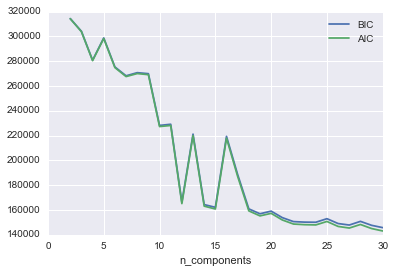

In [48]:
n_components = np.arange(2, 31)
models = [GMM(n, covariance_type='full', random_state=0).fit(d_sc)
          for n in n_components]

plt.plot(n_components, [m.bic(d_sc) for m in models], label='BIC')
plt.plot(n_components, [m.aic(d_sc) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')